In [6]:
%matplotlib notebook
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
# from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

from stingray_plus import *

def FRED_plateau(time, t_0, tau_D, tau_R, t_plateau, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    t_peak = np.sqrt(tau_D*tau_R)
    
#     t[t<=0] = 1e-2
#     t[(t-t_plateau) == 0] = t_plateau + 1e-2
    
    rise_mask = ((t <= t_peak) * (t > 0))
    plateau_mask = ((t > t_peak) * (t <= (t_peak + t_plateau)))
    decay_mask = ((t > (t_peak + t_plateau)))
    
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))
    model[plateau_mask] = np.exp(-2.0*np.sqrt(tau_R/tau_D))
    model[decay_mask] = np.exp(-((tau_R/(t[decay_mask]-t_plateau)) + ((t[decay_mask]-t_plateau)/tau_D)))
        
    return (A * model) + C

def FRED(time, t_0, tau_D, tau_R, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))        
    return (A * model) + C
    

# 2020

In [7]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/2020/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir='/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2020/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products/'
plot_dir = root_dir + 'figures/'
    

Working on Macbook


/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

<IPython.core.display.Javascript object>


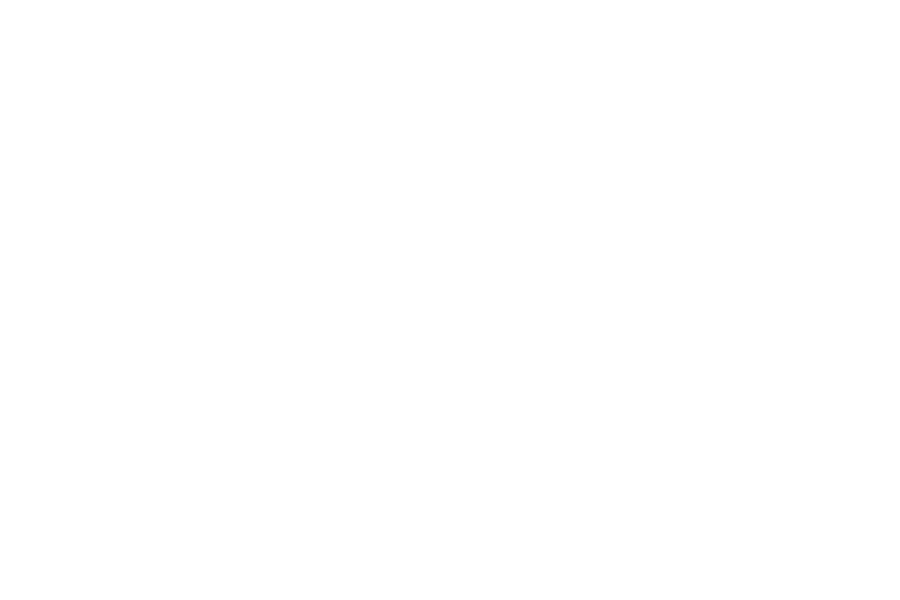

In [8]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu90601307002A01_cl_bc.evt', \
            timing_dir + 'nu90601307002B01_cl_bc.evt')
events[0].set_xy_weights(centroid=[523.42801,455.4582])
events[1].set_xy_weights(centroid=[516.48832,454.64544])
# joined_events = events[0].join(events[1])
# print(events[0].time)

# hk_files = [fits.open(timing_dir + 'nu90601307002A_fpm_bc.hk'), fits.open(timing_dir + 'nu90601307002B_fpm_bc.hk')]
# hk_data_A = hk_files[0][1].data
curveA = nuproducts_to_stingray_lc(products_dir + 'nu90601307002A01_sr.lc')
curveB = nuproducts_to_stingray_lc(products_dir + 'nu90601307002B01_sr.lc')
curve_10s = curveA.rebin(dt_new=10)

t_start = np.min(curveA.time)

plt.figure(figsize = (9,6))
plt.errorbar(curveA.time-t_start, curveA.countrate, xerr=curveA.dt/2., yerr=curveA.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.close()


[2.41476003e+04 1.55823746e+01 9.00928679e-01 4.33205063e+02
 9.68219771e+00]
[3.78846720e+04 1.56188652e+01 6.23679676e-01 3.97167293e+02
 1.14267664e+01]


<IPython.core.display.Javascript object>


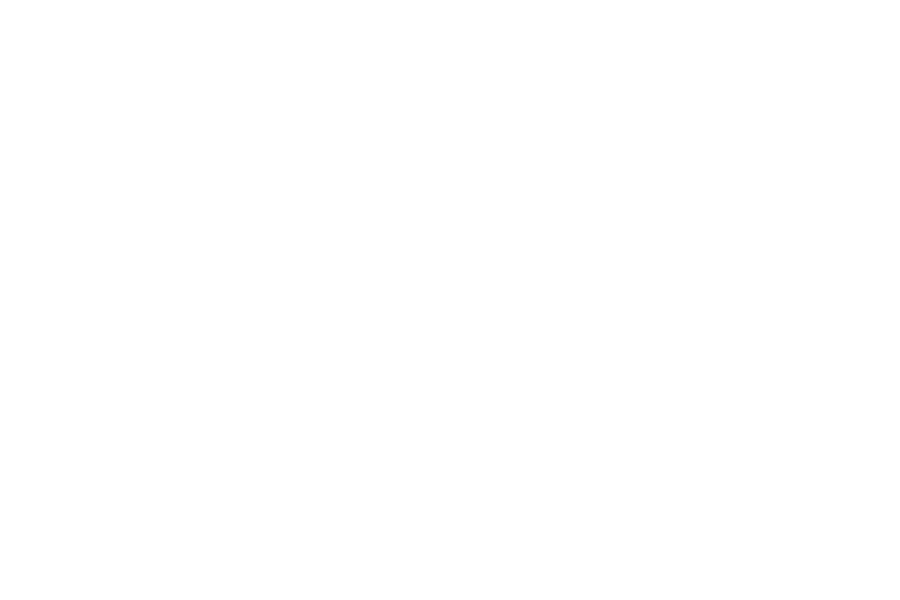

<IPython.core.display.Javascript object>


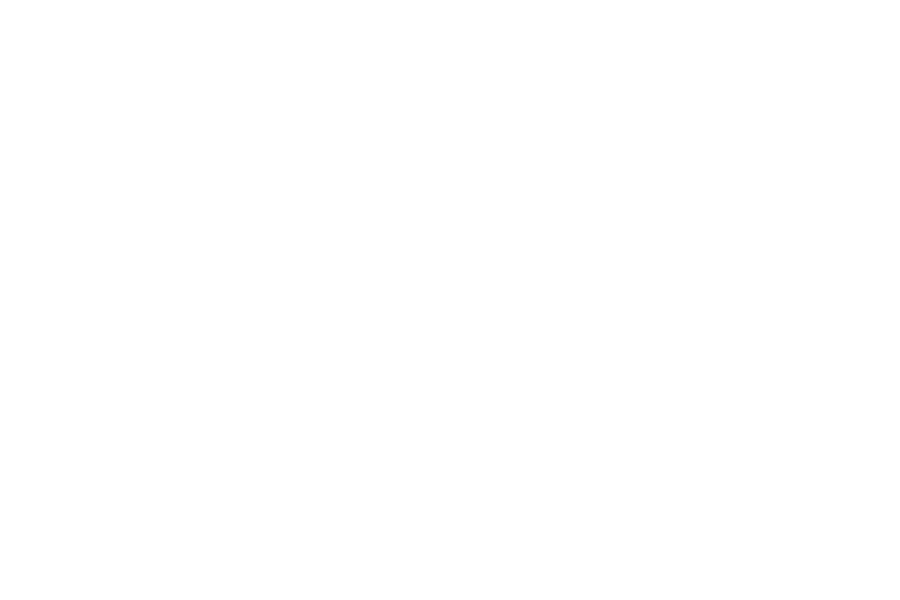

<IPython.core.display.Javascript object>


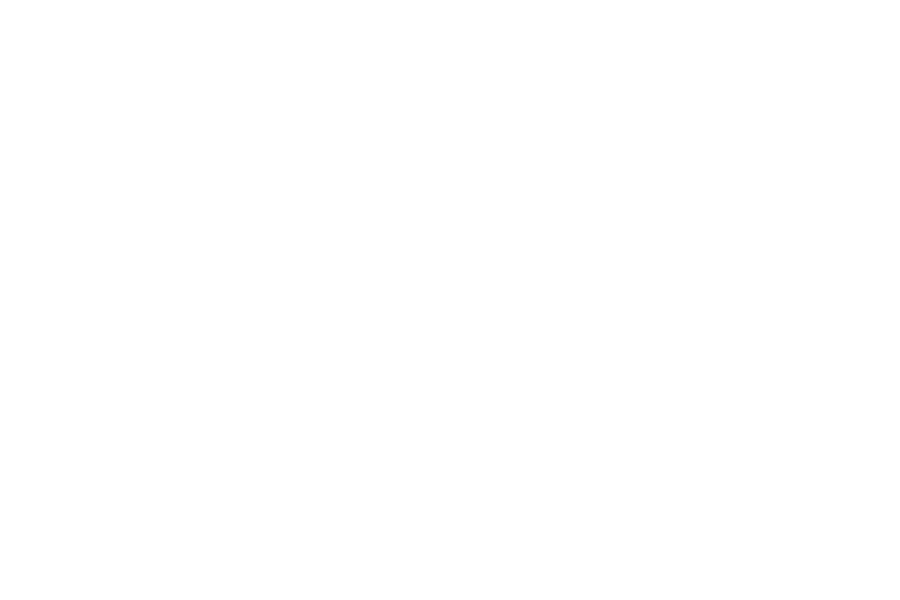

In [9]:
burst1_mask = ((curveA.time-t_start) > 24000) * ((curveA.time-t_start) < 25000)
burst2_mask = ((curveA.time-t_start) > 37800) * ((curveA.time-t_start) < 38200)
curveA.countrate_err[curveA.countrate==0.0] = 1.0

popt1, pcov1 = scipy.optimize.curve_fit(FRED, (curveA.time-t_start)[burst1_mask], curveA.countrate[burst1_mask], \
                                      p0 = [24150., 15., 0.5, 400., 100.], sigma = curveA.countrate_err[burst1_mask], \
                                       bounds = np.array([[24000., 24250], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

popt2, pcov2 = scipy.optimize.curve_fit(FRED, (curveA.time-t_start)[burst2_mask], curveA.countrate[burst2_mask], \
                                      p0 = [37880., 15., 0.5, 400., 12.], sigma = curveA.countrate_err[burst2_mask], \
                                       bounds = np.array([[37800., 38000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# popt1, pcov1 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst1_mask], curveA.countrate[burst1_mask], \
#                                       p0 = [24150., 10., 15., 0.5, 400., 100.], sigma = curveA.countrate_err[burst1_mask], \
#                                        bounds = np.array([[24000., 24250], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# popt2, pcov2 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst2_mask], curveA.countrate[burst2_mask], \
#                                       p0 = [37880., 10., 15., 0.5, 400., 12.], sigma = curveA.countrate_err[burst2_mask], \
#                                        bounds = np.array([[37800., 38000], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

print(popt1)
print(popt2)

plt.figure(figsize = (9,6))
plt.errorbar(curveA.time-t_start, curveA.countrate, xerr=curveA.dt/2., yerr=curveA.countrate_err, fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[burst1_mask], FRED((curveA.time-t_start)[burst1_mask], *popt1))
plt.plot((curveA.time-t_start)[burst2_mask], FRED((curveA.time-t_start)[burst2_mask], *popt2))
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.close()


tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_mask = ((curveA.time-t_start) > tmp_start) * ((curveA.time-t_start) < ((popt1[0]) + (100.*popt1[1])))
plt.figure(figsize = (9,6))
plt.errorbar((curveA.time-t_start)[tmp_mask] - tmp_start, curveA.countrate[tmp_mask], xerr=curveA.dt/2., yerr=curveA.countrate_err[tmp_mask], fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[tmp_mask] - tmp_start, FRED((curveA.time-t_start)[tmp_mask], *popt1), color='C1')
plt.yscale('log')
plt.ylim((2.0,500.))
plt.xlim(10.,1000.)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'burst1_decay.pdf')
plt.close()


tmp_start = (popt2[0] + np.sqrt(popt2[1]*popt2[2])) - 10.
tmp_mask = ((curveA.time-t_start) > tmp_start) * ((curveA.time-t_start) < ((popt2[0]) + (100.*popt2[1])))
plt.figure(figsize = (9,6))
plt.errorbar((curveA.time-t_start)[tmp_mask] - tmp_start, curveA.countrate[tmp_mask], xerr=curveA.dt/2., yerr=curveA.countrate_err[tmp_mask], fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[tmp_mask] - tmp_start, FRED((curveA.time-t_start)[tmp_mask], *popt2), color='C2')
plt.yscale('log')
plt.ylim((2.0,500.))
plt.xlim(10.,1000.)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'burst2_decay.pdf')
plt.close()


burst1_decay_gti = [popt1[0] + np.sqrt(popt1[1]*popt1[2]) + t_start, popt1[0] + t_start + (50.*popt1[1])]
burst2_decay_gti = [popt2[0] + np.sqrt(popt2[1]*popt2[2]) + t_start, popt2[0] + t_start + (50.*popt2[1])]


In [18]:
HR_binsize = 128
buff = 0
total_curve = nuproducts_to_stingray_lc(root_dir + 'products_3to78keV/nu90601307002A01_sr.lc', buffer=False, rebin=False)

soft_curves = [nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/nu90601307002A01_sr.lc', buffer=False, rebin=False), \
               nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/nu90601307002A01_sr.lc', buffer=False, rebin=False)]

hard_curves = [nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/nu90601307002A01_sr.lc', buffer=False, rebin=False), \
               nuproducts_to_stingray_lc(root_dir + 'products_25to50keV/nu90601307002A01_sr.lc', buffer=False, rebin=False)]

soft_total = nuproducts_to_stingray_lc(root_dir + 'products_3to12keV/nu90601307002A01_sr.lc', buffer=False, rebin=False)
hard_total = nuproducts_to_stingray_lc(root_dir + 'products_12to50keV/nu90601307002A01_sr.lc', buffer=False, rebin=False)

# print(soft_curves[1].time == soft_curves[0].time)

common_time = total_curve.time
soft_color = (soft_curves[1].counts)/(soft_curves[0].counts)
soft_err = soft_color*np.sqrt((1.0/soft_curves[1].counts) + (1.0/soft_curves[0].counts))

hard_color = (hard_curves[1].counts)/(hard_curves[0].counts)
hard_err = hard_color*np.sqrt((1.0/hard_curves[1].counts) + (1.0/hard_curves[0].counts))

False
HR = (hard_total.countrate - soft_total.countrate)/(hard_total.countrate + soft_total.countrate)
HR_err = (1.0/(hard_total.countrate + soft_total.countrate))*np.sqrt(np.square((1.0-HR) * hard_total.countrate_err) + np.square((1.0+HR) * soft_total.countrate_err))
plt.ion()




<IPython.core.display.Javascript object>


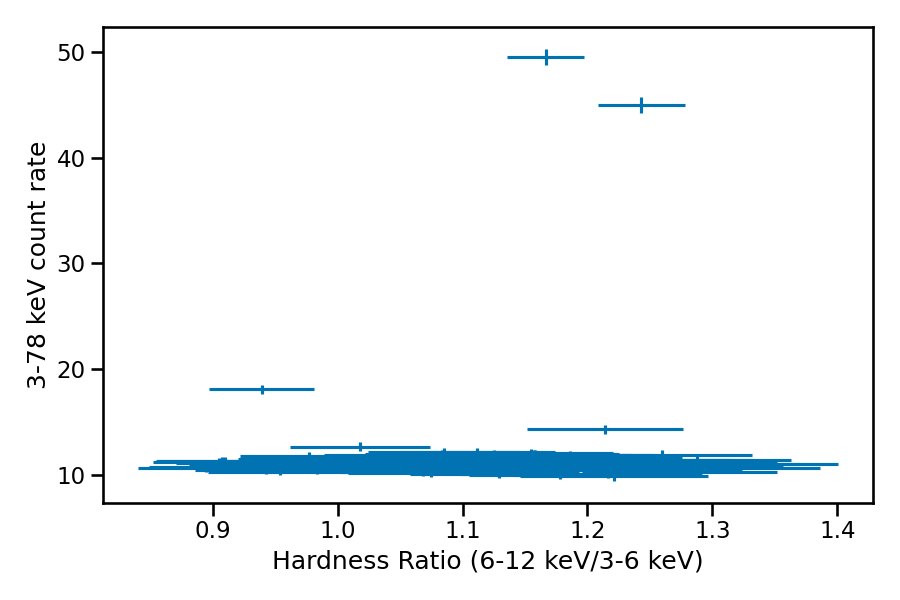

In [19]:
plt.figure(figsize=(9,6))
plt.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()


<IPython.core.display.Javascript object>


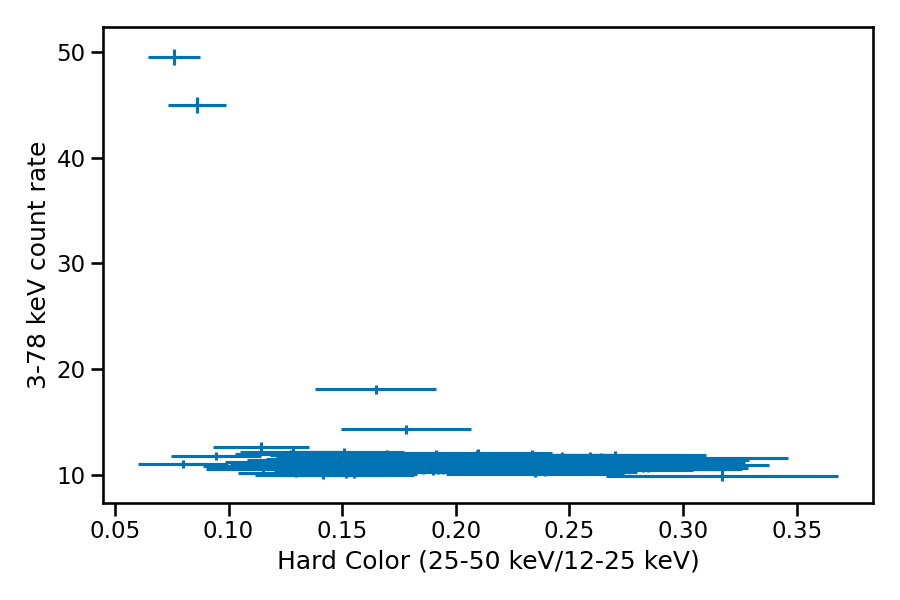

In [20]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, total_curve.countrate, xerr = hard_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()

<IPython.core.display.Javascript object>


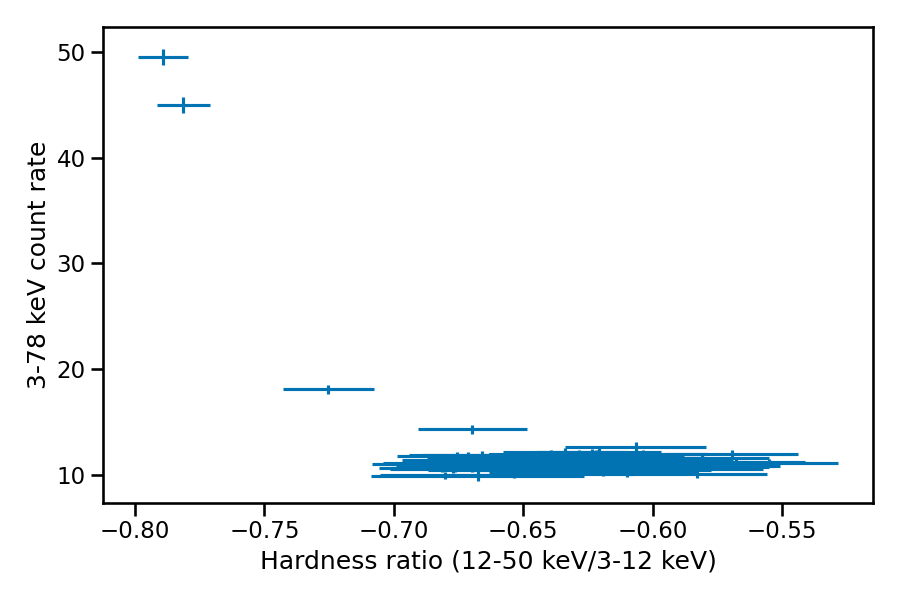

In [14]:
plt.figure(figsize=(9,6))
plt.errorbar(HR, total_curve.counts/total_curve.dt, xerr = HR_err, yerr=total_curve.counts_err/total_curve.dt, fmt='none')
plt.xlabel('Hardness ratio (12-50 keV/3-12 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()

<IPython.core.display.Javascript object>


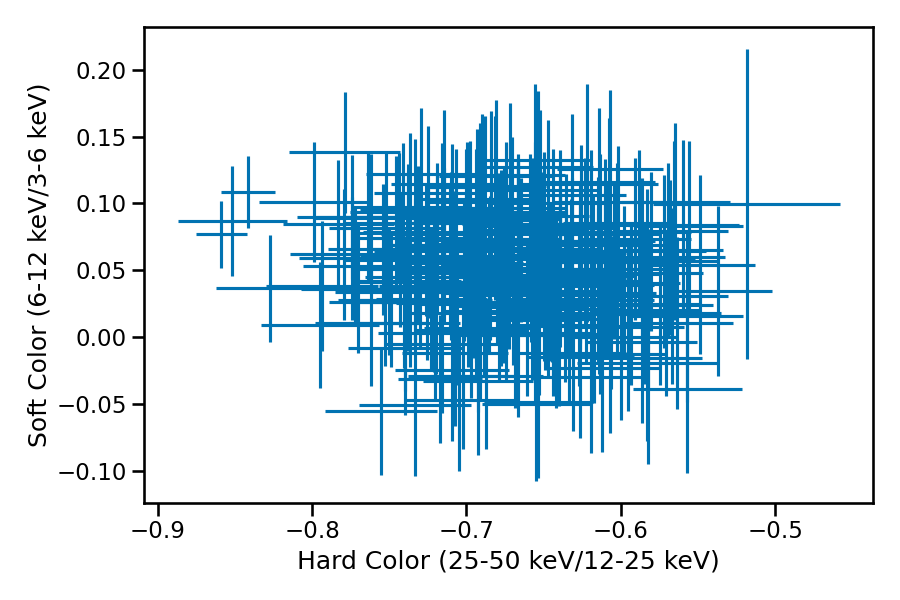

In [15]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, soft_color, xerr = soft_err, yerr=hard_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('Soft Color (6-12 keV/3-6 keV)')
plt.tight_layout()


# 2019

In [19]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/nustar/2019/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2019/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products/'
plot_dir = root_dir + 'figures/'
    

Working on Macbook


In [20]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu90501343002A01_cl_bc.evt', \
            timing_dir + 'nu90501343002B01_cl_bc.evt')
events[0].set_xy_weights(centroid=[455.28246,549.30026])
events[1].set_xy_weights(centroid=[460.50566,550.85167])
# joined_events = events[0].join(events[1])
print(events[0].time)

# hk_files = [fits.open(timing_dir + 'nu90501343002A_fpm_bc.hk'), fits.open(timing_dir + 'nu90501343002B_fpm_bc.hk')]
# hk_data_A = hk_files[0][1].data
curve = nuproducts_to_stingray_lc(products_dir + 'nu90501343002A01_sr.lc')
curve_10s = curve.rebin(dt_new=10)



/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

[3.07665808e+08 3.07665808e+08 3.07665808e+08 ... 3.07748306e+08
 3.07748306e+08 3.07748306e+08]


In [ ]:
HR_binsize = 128
buff = 0
total_curve = nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_3to78keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff)

soft_curves = [nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_3to6keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff), \
               nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_6to12keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff)]

hard_curves = [nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_12to25keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff), \
               nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_25to50keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff)]

soft_total = nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_3to12keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff)
hard_total = nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_12to50keV/nu90501343002A01_sr.lc', buffer=True, rebin=False, buffersize=buff)

# print(soft_curves[1].time == soft_curves[0].time)

common_time = total_curve.time
soft_color = (soft_curves[1].counts - soft_curves[0].counts)/(soft_curves[1].counts + soft_curves[0].counts)
soft_err = (1.0/(soft_curves[1].counts + soft_curves[0].counts))*np.sqrt(np.square((1.0-soft_color) * soft_curves[1].counts_err) + np.square((1.0+soft_color) * soft_curves[0].counts_err))

hard_color = (hard_curves[1].countrate - hard_curves[0].countrate)/(hard_curves[1].countrate + hard_curves[0].countrate)
hard_err = (1.0/(hard_curves[1].countrate + hard_curves[0].countrate))*np.sqrt(np.square((1.0-hard_color) * hard_curves[1].countrate_err) + np.square((1.0+hard_color) * hard_curves[0].countrate_err))

HR = (hard_total.countrate - soft_total.countrate)/(hard_total.countrate + soft_total.countrate)
HR_err = (1.0/(hard_total.countrate + soft_total.countrate))*np.sqrt(np.square((1.0-HR) * hard_total.countrate_err) + np.square((1.0+HR) * soft_total.countrate_err))
plt.ion()



In [ ]:
soft_bins = [[-0.223, -0.18], [-0.18, -0.155], [-0.155, -0.13], [-0.13, -0.095], [-0.095, -0.06],[-0.06, -0.023], [-0.023, 0.03]]
# edge = np.min(soft_color)
# while edge < np.max(soft_color):
#     soft_bins.append([edge, edge + 3*np.mean(soft_err)])
#     edge += 3*np.mean(soft_err)
# print(soft_bins)

plt.figure(figsize=(9,6))
plt.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
plt.ylabel('3-78 keV count rate')
# for b in soft_bins:
#     plt.axvline(b[0], color='red')
# plt.axvline(soft_bins[-1][1], color='red')
plt.tight_layout()
print(np.min(soft_color))
print(np.max(soft_color))
print(np.mean(soft_err))

In [ ]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, total_curve.countrate, xerr = hard_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(9,6))
plt.errorbar(HR, total_curve.counts/total_curve.dt, xerr = HR_err, yerr=total_curve.counts_err/total_curve.dt, fmt='none')
plt.xlabel('Hardness ratio (12-50 keV/3-12 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, soft_color, xerr = soft_err, yerr=hard_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('Soft Color (6-12 keV/3-6 keV)')
plt.tight_layout()


In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})
ax1.errorbar(total_curve.time, total_curve.countrate, xerr = total_curve.dt/2, yerr=total_curve.countrate_err, fmt='none', lw=1.0)
ax2.errorbar(total_curve.time, soft_color, xerr = total_curve.dt/2, yerr=soft_err, fmt='none', lw=1.0)
ax3.errorbar(total_curve.time, hard_color, xerr = total_curve.dt/2, yerr=hard_err, fmt='none', lw=1.0)
ax4.errorbar(total_curve.time, HR, xerr = total_curve.dt/2, yerr=HR_err, fmt='none', lw=1.0)

for b in soft_bins:
    ax2.axhline(b[0], color='red')
ax2.axhline(soft_bins[-1][1], color='red')

plt.tight_layout()



In [ ]:
soft_bins = [[-0.223, -0.18], [-0.18, -0.155], [-0.155, -0.13], [-0.13, -0.095], [-0.095, -0.06],[-0.06, -0.023], [-0.023, 0.03]]
# edge = np.min(soft_color)
# while edge < np.max(soft_color):
#     soft_bins.append([edge, edge + 3*np.mean(soft_err)])
#     edge += 3*np.mean(soft_err)
# print(soft_bins)

plt.figure(figsize=(9,6))
plt.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Soft Color (6-12 keV/3-6 keV)')
plt.ylabel('3-78 keV count rate')
for b in soft_bins:
    plt.axvline(b[0], color='red')
plt.axvline(soft_bins[-1][1], color='red')
plt.tight_layout()
print(np.min(soft_color))
print(np.max(soft_color))
print(np.mean(soft_err))

In [ ]:
palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True, gridspec_kw = {'width_ratios':[3,2], 'wspace':0})
for k, b in enumerate(soft_bins):
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    ax1.errorbar((total_curve.time-np.min(total_curve.time))[soft_mask], total_curve.countrate[soft_mask], \
                 xerr = total_curve.dt/2, yerr=total_curve.countrate_err[soft_mask], color = 'C'+str(k), fmt='none')
    ax2.errorbar(soft_color[soft_mask], total_curve.countrate[soft_mask], xerr = soft_err[soft_mask], \
                 yerr=total_curve.countrate_err[soft_mask],color = 'C'+str(k), fmt='none')
    ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')

# ax2.yaxis.tick_right()
ax2.tick_params(axis='y', which='right', labelright='on')
ax1.set_ylabel('3-78 keV count rate')
ax1.set_xlabel('Time (s)')
plt.tight_layout()
plt.savefig(plot_dir + 'lightcurve_softcolor.pdf')



In [ ]:
soft_gti = []
for b in soft_bins:
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    masked_times = total_curve.time[soft_mask]
    temp_gti = []
    start = masked_times[0]-64.0
    end = masked_times[0]+64.0
    for t in masked_times[1:]:
        if not np.abs(t-64.0 - end) < 10.0:
            temp_gti.append([start, end])
            start = t-64.0
        end = t + 64.0
    temp_gti.append([start, end])
    soft_gti.append(temp_gti)
    plt.figure(figsize=(9,6))
    plt.errorbar(total_curve.time[soft_mask], total_curve.countrate[soft_mask], xerr = total_curve.dt/2, yerr=total_curve.countrate_err[soft_mask], fmt='none', lw=1.0)
    plt.tight_layout()


print(soft_gti)
    

In [ ]:
gti_sum = 0
name_list = ['soft_soft', 'soft', 'soft_mid', 'mid', 'hard_mid', 'hard', 'hard_hard']
for i, x in enumerate(soft_gti):
    print(np.array(x))
#     print(np.array(x).T[0])
#     print(np.array(x).T[1])
    col1 = fits.Column(name='START', format='D', array=np.array(x).T[0])
    col2 = fits.Column(name='STOP', format='D', array=np.array(x).T[1])
    coldefs = fits.ColDefs([col1, col2])
    hdu = fits.BinTableHDU.from_columns(coldefs, name='GTI')
#     hdu.writeto('/disk/lif2/spike/J1739m285/' + name_list[i] + '.gti', overwrite=True)
    for g in x:
#         print(g[1]-g[0])
        gti_sum += g[1]-g[0]
# print(gti_sum) 
# print(128*len(total_curve.time))

In [ ]:
lw = 1.5
ls=''

file_eeufspec = open('/disk/lif2/spike/J1739m285/sim_states_fitting/tbabs_diskbb_bb_relxillNS_eeufspec.qdp', 'r')
file_chi = open('/disk/lif2/spike/J1739m285/sim_states_fitting/tbabs_diskbb_bb_relxillNS_chi.qdp', 'r')
file_ratio = open('/disk/lif2/spike/J1739m285/sim_states_fitting/tbabs_diskbb_bb_relxillNS_ratio.qdp', 'r')
file_model = open('/disk/lif2/spike/J1739m285/sim_states_fitting/tbabs_diskbb_bb_relxillNS_model.qdp', 'r')

data_eeufspec = read_QDP(file_eeufspec)
data_chi = read_QDP(file_chi)
data_ratio = read_QDP(file_ratio)
data_model = read_QDP(file_model)

file_noref = open('/disk/lif2/spike/J1739m285/products/tbabs_diskbb_bb_eeufspec.qdp', 'r')
file_relline = open('/disk/lif2/spike/J1739m285/products/tbabs_diskbb_bb_relline_eeufspec.qdp', 'r')
file_noref_cutoffpl = open('/disk/lif2/spike/J1739m285/products/tbabs_diskbb_cutoffpl_eeufspec.qdp', 'r')
file_ldata = open('/disk/lif2/spike/J1739m285/products/ldata.qdp', 'r')
file_meanspec = open('/disk/lif2/spike/J1739m285/products/tbabs_diskbb_bb_relxillNS_eeufspec.qdp', 'r')

data_noref = read_QDP(file_noref)
data_relline = read_QDP(file_relline)
data_ldata = read_QDP(file_ldata)
data_noref_cutoffpl = read_QDP(file_noref_cutoffpl)
data_meanspec = read_QDP(file_meanspec)

file_cutoffpl_relxill = open('/disk/lif2/spike/J1739m285/products/tbabs_cutoffpl_relxill_eeufspec.qdp', 'r')
file_cutoffpl_relxill_gabs = open('/disk/lif2/spike/J1739m285/products/gabs_tbabs_cutoffpl_relxill_eeufspec.qdp', 'r')
file_cutoffpl_only = open('/disk/lif2/spike/J1739m285/products/tbabs_cutoffpl_eeufspec.qdp', 'r')
file_model_cutoffpl = open('/disk/lif2/spike/J1739m285/sim_states_fitting/gabs_tbabs_cutoffpl_relxill_model.qdp', 'r')
file_eeufspec_cutoffpl = open('/disk/lif2/spike/J1739m285/sim_states_fitting/gabs_tbabs_cutoffpl_relxill_eeufspec.qdp', 'r')

data_cutoffpl_relxill = read_QDP(file_cutoffpl_relxill)
data_cutoffpl_relxill_gabs = read_QDP(file_cutoffpl_relxill_gabs)
data_cutoffpl_only = read_QDP(file_cutoffpl_only)
data_model_cutoffpl = read_QDP(file_model_cutoffpl)
data_eeufspec_cutoffpl = read_QDP(file_eeufspec_cutoffpl)



In [ ]:
# When plotting QDP, the 0th column is X, 1st is X error, 2nd is Y, 3rd is Y error, and 4th is the model
label_list = ['Extra Soft', 'Soft', 'Soft-mid', 'Mid', 'Hard-mid', 'Hard', 'Extra Hard']
name_list = ['soft_soft', 'soft', 'soft_mid', 'mid', 'hard_mid', 'hard', 'hard_hard']

palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
plt.figure(figsize=(10,5))
lw = 1.5
# ls = 'steps'
ls=''
for i in range(len(data_eeufspec)):
    if not i%2:
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][2], xerr=data_eeufspec[i][1], yerr=data_eeufspec[i][3], \
                     ls=ls, lw=lw, color='C' + str(int(i/2)), label = label_list[int(i/2)])
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][4], xerr=data_eeufspec[i][1], \
                     ls='steps-mid', color='C' + str(int(i/2)), lw=lw)

# for i in range(len(data_pl)):
#     plt.errorbar(data_pl[i][0],data_pl[i][2], xerr=data_pl[i][1], yerr=data_pl[i][3], \
#                  ls =ls, color='C' + str(int(len(data_sim) + i)), lw=lw, label='0780950201')

# for i in range(len(data_high)):
#     plt.errorbar(data_high[i][0],data_high[i][2], xerr=data_high[i][1], yerr=data_high[i][3], \
#                  ls =ls, color='magenta', lw=lw, label='0824450301')
    
# plt.legend()
plt.loglog()
plt.xlim((3.0,25.0))
plt.ylim((0.1,2.5))
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().xaxis.set_minor_formatter(ScalarFormatter())
plt.xticks([10.0], ['10'])
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\mathrm{EF_E\ [keV^{2}(\gamma\,cm^{-2}\,s^{-1}\,keV^{-1})]}$')
plt.tight_layout()
plt.savefig(plot_dir + 'all_states_FPMA_eeufspec.pdf')
plt.close()

plt.figure(figsize=(8,8))
lw = 1.0
# ls = 'steps'
ls=''
for i in range(len(data_eeufspec)):
    if not i%2:
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][2], xerr=data_eeufspec[i][1], yerr=data_eeufspec[i][3], \
                     ls=ls, lw=lw, color='C' + str(int(i/2)), label = label_list[int(i/2)])
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][4], xerr=data_eeufspec[i][1], \
                     ls='steps-mid', color='C' + str(int(i/2)), lw=lw)

# for i in range(len(data_pl)):
#     plt.errorbar(data_pl[i][0],data_pl[i][2], xerr=data_pl[i][1], yerr=data_pl[i][3], \
#                  ls =ls, color='C' + str(int(len(data_sim) + i)), lw=lw, label='0780950201')

# for i in range(len(data_high)):
#     plt.errorbar(data_high[i][0],data_high[i][2], xerr=data_high[i][1], yerr=data_high[i][3], \
#                  ls =ls, color='magenta', lw=lw, label='0824450301')
    
# plt.legend()
plt.loglog()
plt.xlim((3.0,25.0))
plt.ylim((0.1,2.5))
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xticks([10.0], ['10'])
plt.gca().xaxis.set_minor_formatter(ScalarFormatter())
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\mathrm{EF_E\ [keV^{2}(\gamma\,cm^{-2}\,s^{-1}\,keV^{-1})]}$')
plt.tight_layout()
plt.savefig(plot_dir + 'all_states_FPMA_eeufspec_tall.pdf')
plt.close()




In [ ]:
# When plotting QDP, the 0th column is X, 1st is X error, 2nd is Y, 3rd is Y error, and 4th is the model
label_list = ['Extra Soft', 'Soft', 'Soft-mid', 'Mid', 'Hard-mid', 'Hard', 'Extra Hard']
name_list = ['soft_soft', 'soft', 'soft_mid', 'mid', 'hard_mid', 'hard', 'hard_hard']

palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
plt.figure(figsize=(10,5))
lw = 1.5
# ls = 'steps'
ls=''
for i in range(len(data_eeufspec)):
    if not i%2:
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][2], xerr=data_eeufspec[i][1], yerr=data_eeufspec[i][3], \
                     ls=ls, lw=lw, color='C' + str(int(i/2)), label = label_list[int(i/2)])
        plt.errorbar(data_eeufspec[i][0],data_eeufspec[i][4], xerr=data_eeufspec[i][1], \
                     ls='steps-mid', color='C' + str(int(i/2)), lw=lw)

# for i in range(len(data_pl)):
#     plt.errorbar(data_pl[i][0],data_pl[i][2], xerr=data_pl[i][1], yerr=data_pl[i][3], \
#                  ls =ls, color='C' + str(int(len(data_sim) + i)), lw=lw, label='0780950201')

# for i in range(len(data_high)):
#     plt.errorbar(data_high[i][0],data_high[i][2], xerr=data_high[i][1], yerr=data_high[i][3], \
#                  ls =ls, color='magenta', lw=lw, label='0824450301')
    
plt.legend()
plt.loglog()
plt.xlim((3.0,25.0))
plt.ylim((0.1,2.5))
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\mathrm{EF_E\ [keV^{2}(\gamma\,cm^{-2}\,s^{-1}\,keV^{-1})]}$')
plt.tight_layout()
plt.savefig(plot_dir + 'all_states_FPMA_cutoffpl_eeufspec.pdf')
# plt.close()




In [ ]:
sns.set_palette('colorblind')
lw = 1.5
# ls = 'steps'
ls=''
for i in range(len(data_eeufspec)):
    if not i%2:
        fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1], 'hspace':0}, figsize=(9, 6))
        ax1.errorbar(data_eeufspec[i][0],data_eeufspec[i][2], xerr=data_eeufspec[i][1], yerr=data_eeufspec[i][3], \
                     ls=ls, lw=lw, color='C0', label = 'FPMA')
        ax1.errorbar(data_eeufspec[i][0],data_eeufspec[i][4], xerr=data_eeufspec[i][1], \
                     ls='steps-mid', color='C0', lw=lw)
        ax1.errorbar(data_eeufspec[i+1][0],data_eeufspec[i+1][2], xerr=data_eeufspec[i+1][1], yerr=data_eeufspec[i+1][3], \
                     ls=ls, lw=lw, color='C1', label = 'FPMB')
        ax1.errorbar(data_eeufspec[i+1][0],data_eeufspec[i+1][4], xerr=data_eeufspec[i+1][1], \
                     ls='steps-mid', color='C1', lw=lw)
        
        ax1.plot(data_eeufspec[i][0],data_eeufspec[i][5], color='black', lw=1.0, ls = '--')
        ax1.plot(data_eeufspec[i][0],data_eeufspec[i][6], color='black', lw=1.0, ls = ':')
        ax1.plot(data_eeufspec[i][0],data_eeufspec[i][7], color='black', lw=1.0, ls = '-.')

        ax2.errorbar(data_eeufspec[i][0],(data_eeufspec[i][2]-data_eeufspec[i][4])/data_eeufspec[i][3], xerr=data_eeufspec[i][1], yerr=1.0, \
                     ls=ls, color='C0', lw=lw)
        ax2.errorbar(data_eeufspec[i+1][0],(data_eeufspec[i+1][2] - data_eeufspec[i+1][4])/data_eeufspec[i+1][3], xerr=data_eeufspec[i+1][1],yerr=1.0, \
                     ls=ls, color='C1', lw=lw)
        
        ax1.legend()
        ax1.loglog()
        plt.xlabel('Energy (keV)')
        ax1.set_ylabel(r'$\mathrm{EF_E\ [keV^{2}(\gamma\,cm^{-2}\,s^{-1}\,keV^{-1})]}$', fontsize=15)
        ax2.set_ylabel(r'$\frac{(data-model)}{error}$')
        ax1.set_ylim((3e-3, 3.0))
        ax2.set_ylim((-4.5,4.5))
        ax2.set_xlim((2.8,42.0))
        ax1.set_xlim((2.8,42.0))
        ax2.axhline(0,color='cyan', lw=1.0)
        plt.tight_layout()
        plt.savefig(plot_dir + 'eeufspec_resid_' + name_list[int(i/2)] + '.pdf')
#         plt.close()




In [ ]:
sns.set_palette('colorblind')
lw = 1.5
# ls = 'steps'
ls=''
for i in range(len(data_eeufspec_cutoffpl)):
    if not i%2:
        fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1], 'hspace':0}, figsize=(9, 6))
        ax1.errorbar(data_eeufspec_cutoffpl[i][0],data_eeufspec_cutoffpl[i][2], xerr=data_eeufspec_cutoffpl[i][1], yerr=data_eeufspec_cutoffpl[i][3], \
                     ls=ls, lw=lw, color='C0', label = 'FPMA')
        ax1.errorbar(data_eeufspec_cutoffpl[i][0],data_eeufspec_cutoffpl[i][4], xerr=data_eeufspec_cutoffpl[i][1], \
                     ls='steps-mid', color='C0', lw=lw)
        ax1.errorbar(data_eeufspec_cutoffpl[i+1][0],data_eeufspec_cutoffpl[i+1][2], xerr=data_eeufspec_cutoffpl[i+1][1], yerr=data_eeufspec_cutoffpl[i+1][3], \
                     ls=ls, lw=lw, color='C1', label = 'FPMB')
        ax1.errorbar(data_eeufspec_cutoffpl[i+1][0],data_eeufspec_cutoffpl[i+1][4], xerr=data_eeufspec_cutoffpl[i+1][1], \
                     ls='steps-mid', color='C1', lw=lw)
        
        ax1.plot(data_eeufspec_cutoffpl[i][0],data_eeufspec_cutoffpl[i][5], color='black', lw=1.0, ls = '--')
        ax1.plot(data_eeufspec_cutoffpl[i][0],data_eeufspec_cutoffpl[i][6], color='black', lw=1.0, ls = ':')

        ax2.errorbar(data_eeufspec_cutoffpl[i][0],(data_eeufspec_cutoffpl[i][2]-data_eeufspec_cutoffpl[i][4])/data_eeufspec_cutoffpl[i][3], xerr=data_eeufspec_cutoffpl[i][1], yerr=1.0, \
                     ls=ls, color='C0', lw=lw)
        ax2.errorbar(data_eeufspec_cutoffpl[i+1][0],(data_eeufspec_cutoffpl[i+1][2] - data_eeufspec_cutoffpl[i+1][4])/data_eeufspec_cutoffpl[i+1][3], xerr=data_eeufspec_cutoffpl[i+1][1],yerr=1.0, \
                     ls=ls, color='C1', lw=lw)
        
        ax1.legend()
        ax1.loglog()
        plt.xlabel('Energy (keV)')
        ax1.set_ylabel(r'$\mathrm{EF_E\ [keV^{2}(\gamma\,cm^{-2}\,s^{-1}\,keV^{-1})]}$', fontsize=15)
        ax2.set_ylabel(r'$\frac{(data-model)}{error}$')
        ax1.set_ylim((3e-3, 3.0))
        ax2.set_ylim((-4.5,4.5))
        ax2.set_xlim((2.8,42.0))
        ax1.set_xlim((2.8,42.0))
        ax2.axhline(0,color='cyan', lw=1.0)
        plt.tight_layout()
        plt.savefig(plot_dir + 'eeufspec_cutoffpl_resid_' + name_list[int(i/2)] + '.pdf')
#         plt.close()




In [ ]:
palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
lw = 1.5
# ls = 'steps'

# fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2,1,  gridspec_kw = {'height_ratios':[1, 1]}, figsize=(9, 12))
plt.ticklabel_format(style='plain')
for i in range(len(data_model)):
    if not i%2:
        ax1.plot(data_model[i][0], data_model[i][2], color='C' + str(int(i/2)), lw = 1.0)
        ax1.plot(data_model[i][0], data_model[i][3], ls='--', color='C' + str(int(i/2)), lw = 1.0)
        ax1.plot(data_model[i][0], data_model[i][4], ls=':', color='C' + str(int(i/2)), lw = 1.0)
        ax1.plot(data_model[i][0], data_model[i][5], ls='-.', color='C' + str(int(i/2)), lw = 1.0)

#         ax2.errorbar(data_eeufspec[i][0],(data_eeufspec[i][2]-data_eeufspec[i][4])/data_eeufspec[i][3], xerr=data_eeufspec[i][1], yerr=1.0, \
#                      ls=ls, color='C0', lw=lw)
#         ax2.errorbar(data_eeufspec[i+1][0],(data_eeufspec[i+1][2] - data_eeufspec[i+1][4])/data_eeufspec[i+1][3], xerr=data_eeufspec[i+1][1],yerr=1.0, \
#                      ls=ls, color='C1', lw=lw)
#         ax1.legend()
ax1.set_xlim((2.0,40.0))
ax1.set_ylim((1e-5,0.3))
ax1.loglog()
ax1.set_xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=15)


for k, b in enumerate(soft_bins):
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    ax2.errorbar(soft_color[soft_mask], total_curve.countrate[soft_mask], xerr = soft_err[soft_mask], yerr=total_curve.countrate_err[soft_mask], fmt='none', color = 'C' + str(k), lw = 1.0)
ax2.set_xlabel('Soft Color (6-12 keV/3-6 keV)')
ax2.set_ylabel('3-78 keV count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'model_all_states.pdf')
#         plt.close()




In [ ]:
palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
lw = 1.5
# ls = 'steps'

# fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2,1,  gridspec_kw = {'height_ratios':[1, 1]}, figsize=(9, 12))

for i in range(len(data_model_cutoffpl)):
    if not i%2:
        ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][2], color='C' + str(int(i/2)), lw = 1.0)
        ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][3], ls='--', color='C' + str(int(i/2)), lw = 1.0)
        ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][4], ls=':', color='C' + str(int(i/2)), lw = 1.0)


ax1.set_xlim((2.0,40.0))
ax1.set_ylim((1e-5,0.3))
ax1.loglog()
ax1.set_xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=15)

for k, b in enumerate(soft_bins):
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    ax2.errorbar(soft_color[soft_mask], total_curve.countrate[soft_mask], xerr = soft_err[soft_mask], yerr=total_curve.countrate_err[soft_mask], fmt='none', color = 'C' + str(k), lw = 1.0)
ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
ax2.set_ylabel('3-78 keV count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'model_cutoffpl_all_states.pdf')
#         plt.close()




In [ ]:
palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
lw = 1.5
# ims = []
for k, b in enumerate(soft_bins):
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    
    fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(12, 6))

    for i in range(len(data_model)):
        if not i%2:
            ax1.plot(data_model[i][0], data_model[i][2], color='C' + str(int(i/2)), alpha=0.1)
            ax1.plot(data_model[i][0], data_model[i][3], ls='--', color='C' + str(int(i/2)), alpha=0.1)
            ax1.plot(data_model[i][0], data_model[i][4], ls=':', color='C' + str(int(i/2)), alpha=0.1)
            ax1.plot(data_model[i][0], data_model[i][5], ls='-.', color='C' + str(int(i/2)), alpha=0.1)
            if k==int(i/2):
                ax1.plot(data_model[i][0], data_model[i][2], color='C' + str(k))
                ax1.plot(data_model[i][0], data_model[i][3], ls='--', color='C' + str(k))
                ax1.plot(data_model[i][0], data_model[i][4], ls=':', color='C' + str(k))
                ax1.plot(data_model[i][0], data_model[i][5], ls='-.', color='C' + str(k))
    

    #         ax2.errorbar(data_eeufspec[i][0],(data_eeufspec[i][2]-data_eeufspec[i][4])/data_eeufspec[i][3], xerr=data_eeufspec[i][1], yerr=1.0, \
    #                      ls=ls, color='C0', lw=lw)
    #         ax2.errorbar(data_eeufspec[i+1][0],(data_eeufspec[i+1][2] - data_eeufspec[i+1][4])/data_eeufspec[i+1][3], xerr=data_eeufspec[i+1][1],yerr=1.0, \
    #                      ls=ls, color='C1', lw=lw)
    #         ax1.legend()
    ax1.plot([0,1], [0,1], ls='--', color='black', label='Disk bb')
    ax1.plot([0,1], [0,1], ls=':', color='black', label='NS bb')
    ax1.plot([0,1], [0,1], ls='-.', color='black', label='Reflection')
    ax1.legend(loc = 1)
    ax1.set_xlim((2.0,40.0))
    ax1.set_ylim((1e-5,0.3))
    ax1.loglog()
    ax1.set_xlabel('Energy (keV)')
    ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=20)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    ax1.set_xticks([2,3,4,5,6,7,8,9,20,30,40], minor = True)
    ax1.set_xticklabels(['2','','','5','','','','','20','30','40'], minor=True)
    ax1.set_xticks([10], minor = False)
    ax1.set_xticklabels(['10'], minor=False)
    
    ax2.errorbar(soft_color[soft_mask], total_curve.countrate[soft_mask], xerr = soft_err[soft_mask], yerr=total_curve.countrate_err[soft_mask], fmt='none', color = 'C' + str(k))
    
    for l, c in enumerate(soft_bins):
        if k != l:
            temp_mask = (soft_color < c[1]) * (soft_color >= c[0])
            ax2.errorbar(soft_color[temp_mask], total_curve.countrate[temp_mask], xerr = soft_err[temp_mask], yerr=total_curve.countrate_err[temp_mask], fmt='none', color = 'C' + str(l), alpha=0.05)


    ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
    ax2.set_ylabel('3-78 keV count rate', fontsize=20)
    plt.tight_layout()
    plt.savefig(plot_dir + 'model_' + name_list[k] + '_rainbow.png')
    #         plt.close()

# fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(10, 5))

# for i in range(len(data_model)):
#     if not i%2:
#         ax1.plot(data_model[i][0], data_model[i][2], color='C0')
#         ax1.plot(data_model[i][0], data_model[i][3], ls='--', color='C0')
#         ax1.plot(data_model[i][0], data_model[i][4], ls=':', color='C0')
#         ax1.plot(data_model[i][0], data_model[i][5], ls='-.', color='C0')

# ax1.set_xlim((2.0,40.0))
# ax1.set_ylim((1e-5,0.3))
# ax1.loglog()
# ax1.set_xlabel('Energy (keV)')
# ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=15)

# ax2.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none', color = 'C0')


# ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
# ax2.set_ylabel('3-78 keV count rate')
# plt.tight_layout()
# # plt.savefig(plot_dir + 'model_all_softcolor_talk.pdf')




In [ ]:
palette = reversed(sns.color_palette('rainbow', 7))
sns.set_palette(palette, 7)
lw = 1.5
# ims = []
for k, b in enumerate(soft_bins):
    soft_mask = (soft_color < b[1]) * (soft_color >= b[0])
    
    fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(12, 6))

    for i in range(len(data_model)):
        if not i%2:
            ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][2], color='C' + str(int(i/2)), alpha=0.1)
            ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][3], ls='--', color='C' + str(int(i/2)), alpha=0.1)
            ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][4], ls=':', color='C' + str(int(i/2)), alpha=0.1)
            if k==int(i/2):
                ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][2], color='C' + str(k))
                ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][3], ls='--', color='C' + str(k))
                ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][4], ls=':', color='C' + str(k))


    #         ax2.errorbar(data_eeufspec[i][0],(data_eeufspec[i][2]-data_eeufspec[i][4])/data_eeufspec[i][3], xerr=data_eeufspec[i][1], yerr=1.0, \
    #                      ls=ls, color='C0', lw=lw)
    #         ax2.errorbar(data_eeufspec[i+1][0],(data_eeufspec[i+1][2] - data_eeufspec[i+1][4])/data_eeufspec[i+1][3], xerr=data_eeufspec[i+1][1],yerr=1.0, \
    #                      ls=ls, color='C1', lw=lw)
    #         ax1.legend()
    ax1.set_xlim((2.0,40.0))
    ax1.set_ylim((1e-5,0.3))
    ax1.loglog()
    ax1.set_xlabel('Energy (keV)')
    ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=20)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    ax1.set_xticks([2,3,4,5,6,7,8,9,20,30,40], minor = True)
    ax1.set_xticklabels(['2','','','5','','','','','20','30','40'], minor=True)
    ax1.set_xticks([10], minor = False)
    ax1.set_xticklabels(['10'], minor=False)
    
    ax2.errorbar(soft_color[soft_mask], total_curve.countrate[soft_mask], xerr = soft_err[soft_mask], yerr=total_curve.countrate_err[soft_mask], fmt='none', color = 'C' + str(k))
    
    for l, c in enumerate(soft_bins):
        if k != l:
            temp_mask = (soft_color < c[1]) * (soft_color >= c[0])
            ax2.errorbar(soft_color[temp_mask], total_curve.countrate[temp_mask], xerr = soft_err[temp_mask], yerr=total_curve.countrate_err[temp_mask], fmt='none', color = 'C' + str(l), alpha=0.05)


    ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
    ax2.set_ylabel('3-78 keV count rate', fontsize=20)
    plt.tight_layout()
    plt.savefig(plot_dir + 'model_cutoffpl_' + name_list[k] + '_rainbow.pdf')



# fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'hspace':0}, figsize=(10, 5))

# for i in range(len(data_model_cutoffpl)):
#     if not i%2:
#         ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][2], color='C0')
#         ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][3], ls='--', color='C0')
#         ax1.plot(data_model_cutoffpl[i][0], data_model_cutoffpl[i][4], ls=':', color='C0')

# ax1.set_xlim((2.0,40.0))
# ax1.set_ylim((1e-5,0.3))
# ax1.loglog()
# ax1.set_xlabel('Energy (keV)')
# ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=15)

# ax2.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none', color = 'C0')


# ax2.set_xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
# ax2.set_ylabel('3-78 keV count rate')
# plt.tight_layout()
# plt.savefig(plot_dir + 'model_cutoffpl_all_softcolor_talk.pdf')




In [ ]:
sns.set_palette('colorblind')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1,1,1], 'hspace':0}, figsize=(9, 9))
ax1.errorbar(data_ldata[0][0],data_ldata[0][2], xerr=data_ldata[0][1], yerr=data_ldata[0][3], \
             ls=ls, lw=lw, color='C0', label = 'FPMA')
ax1.errorbar(data_ldata[1][0],data_ldata[1][2], xerr=data_ldata[1][1], yerr=data_ldata[1][3], \
             ls=ls, lw=lw, color='C1', label = 'FPMB')

ax2.errorbar(data_cutoffpl_only[0][0],(data_cutoffpl_only[0][2]-data_cutoffpl_only[0][4])/data_cutoffpl_only[0][3], xerr=data_cutoffpl_only[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax2.errorbar(data_cutoffpl_only[1][0],(data_cutoffpl_only[1][2] - data_cutoffpl_only[1][4])/data_cutoffpl_only[1][3], xerr=data_cutoffpl_only[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax3.errorbar(data_cutoffpl_relxill[0][0],(data_cutoffpl_relxill[0][2]-data_cutoffpl_relxill[0][4])/data_cutoffpl_relxill[0][3], xerr=data_cutoffpl_relxill[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax3.errorbar(data_cutoffpl_relxill[1][0],(data_cutoffpl_relxill[1][2] - data_cutoffpl_relxill[1][4])/data_cutoffpl_relxill[1][3], xerr=data_cutoffpl_relxill[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax4.errorbar(data_cutoffpl_relxill_gabs[0][0],(data_cutoffpl_relxill_gabs[0][2]-data_cutoffpl_relxill_gabs[0][4])/data_cutoffpl_relxill_gabs[0][3], xerr=data_cutoffpl_relxill_gabs[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax4.errorbar(data_cutoffpl_relxill_gabs[1][0],(data_cutoffpl_relxill_gabs[1][2] - data_cutoffpl_relxill_gabs[1][4])/data_cutoffpl_relxill_gabs[1][3], xerr=data_cutoffpl_relxill_gabs[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax1.legend()
ax1.loglog()
plt.xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{Photons\,cm^{-2}\,s^{-1}\,keV^{-1}}$', fontsize=15)
# ax2.set_ylabel(r'$\frac{data}{model}$')
# ax2.axhline(1,color='cyan', lw=1.0)
ax3.set_ylabel(r'$\frac{data-model}{error}$')
ax2.axhline(0,color='cyan', lw=1.0)
ax3.axhline(0,color='cyan', lw=1.0)
ax4.axhline(0,color='cyan', lw=1.0)

ax2.set_ylim(-16,16)
ax3.set_ylim(-16,16)
ax4.set_ylim(-16,16)

ax2.text(2.9, -14, 'cutoff powerlaw')
ax3.text(2.9, -14, 'cutoff powerlaw + full reflection')
ax4.text(2.9, -14, 'gaussian absorption(cutoff powerlaw + full reflection)')


plt.tight_layout()
plt.savefig(plot_dir + 'ldata_threecutoffpl_resid.pdf')


